In this notebook, we get the metadata from the SLCs that will be used for processing and in the Elastic Search Databases.

Most importantly, we obtain the bounding box and polygon of the interferogram.

In [1]:
import isce
import isceobj
from iscesys.Component.ProductManager import ProductManager as PM
from jinja2 import Template
from subprocess import check_call, check_output
import os
import site
import zipfile
from pathlib import Path
import isce, isceobj
from isceobj.Alos2Proc.Alos2ProcPublic import getBboxRdr
from shapely.geometry import Polygon, box
import json
import hashlib
import dateparser
import datetime
import sys

This is the Open Source version of ISCE.
Some of the workflows depend on a separate licensed package.
To obtain the licensed package, please make a request for ISCE
through the website: https://download.jpl.nasa.gov/ops/request/index.cfm.
Alternatively, if you are a member, or can become a member of WinSAR
you may be able to obtain access to a version of the licensed sofware at
https://winsar.unavco.org/software/isce
2021-03-24 17:58:28,614 - shapely.geos - DEBUG - Trying `CDLL(libc.so.6)`
2021-03-24 17:58:28,617 - shapely.geos - DEBUG - Library path: 'libc.so.6'
2021-03-24 17:58:28,618 - shapely.geos - DEBUG - DLL: <CDLL 'libc.so.6', handle 7f0b84fce000 at 0x7f09c3028ca0>


In [2]:
## Will be taken care of in papermill script
## If not, we must run jupyter from the `notebooks/` directory
if not os.environ.get('PGE_DIRECTORY'):
    path = Path(os.getcwd()).parents[0]
    os.environ['PGE_DIRECTORY'] = str(path.absolute())
    assert(path.name == 'alos2_scansar_pge')

sys.path.append(os.environ['PGE_DIRECTORY'])
from ifg_tools.rio_tools import reproject_arr_to_match_profile
PGE_DIRECTORY = os.environ['PGE_DIRECTORY']

2021-03-24 17:58:28,832 - rasterio.session - DEBUG - Could not import boto3, continuing with reduced functionality.
2021-03-24 17:58:28,853 - fiona.env - DEBUG - Entering env context: <fiona.env.Env object at 0x7f0b608f26d0>
2021-03-24 17:58:28,854 - fiona.env - DEBUG - Starting outermost env
2021-03-24 17:58:28,855 - fiona.env - DEBUG - No GDAL environment exists
2021-03-24 17:58:28,855 - fiona.env - DEBUG - New GDAL environment <fiona._env.GDALEnv object at 0x7f0b605b7970> created
2021-03-24 17:58:28,856 - fiona._env - DEBUG - Logging error handler pushed.
2021-03-24 17:58:28,860 - fiona._env - DEBUG - All drivers registered.
2021-03-24 17:58:28,860 - fiona._env - DEBUG - GDAL_DATA found in environment: '/u/leffe-data2/cmarshak/miniconda3/envs/isce2/share/gdal'.
2021-03-24 17:58:28,861 - fiona._env - DEBUG - PROJ_LIB found in environment: '/u/leffe-data2/cmarshak/miniconda3/envs/isce2/share/proj'.
2021-03-24 17:58:28,862 - fiona._env - DEBUG - Started GDALEnv <fiona._env.GDALEnv obje

In [3]:
VERSION = 'v1.0.0'

# Read the context file

In [4]:
with open('_context.json') as file:
    ctx = json.load(file)   
ctx

{'_command': '/home/ops/ariamh/interferogram/alos/create_alos2_ifg.sh',
 '_disk_usage': '200GB',
 '_prov': {'wasGeneratedBy': 'task_id:40849cff-93d8-4aef-b1a3-34d607ff4161'},
 'azimuth_looks': '12',
 'burst_overlap': '85.0',
 'container_image_id': 'sha256:2a3dab0bf8f21719d4e90eaafae8ff4b3cb05547917ad361af90649179297fd0',
 'container_image_name': 'container-aria-jpl_ariamh:alos2',
 'container_image_url': 's3://s3-us-west-2.amazonaws.com/aria-ops-code-bucket/container-aria-jpl_ariamh:alos2.tar.gz',
 'container_mappings': {'/home/ops/.aws': ['/home/ops/.aws', 'ro'],
  '/home/ops/.netrc': ['/home/ops/.netrc'],
  '/home/ops/verdi/etc/settings.conf': '/home/ops/ariamh/conf/settings.conf'},
 'container_specification': {'digest': 'sha256:2a3dab0bf8f21719d4e90eaafae8ff4b3cb05547917ad361af90649179297fd0',
  'id': 'container-aria-jpl_ariamh:alos2',
  'url': 's3://s3-us-west-2.amazonaws.com/aria-ops-code-bucket/container-aria-jpl_ariamh:alos2.tar.gz',
  'version': 'alos2'},
 'dem_type': 'SRTM+v3',

# Unzip SLC Data

In [5]:
REFERENCE_ZIP = ctx['reference_product']
SECONDARY_ZIP = ctx['secondary_product']
REFERENCE_ZIP, SECONDARY_ZIP

('ALOS2047853200-150412.zip', 'ALOS2041643200-150301.zip')

In [6]:
def unzip_vol_led_files_alos2(zip_path: str) -> list:
    zip_obj = zipfile.ZipFile(zip_path, 'r')
    
    def vol_led_filter(zip_info_ob):
        file_name = zip_info_ob.filename
        prefixes = ['VOL-', 'LED-', 'IMG-HH-']
        if any(prefix in file_name for prefix in prefixes):
            return True
        else:
            return False
    all_files = zip_obj.filelist
    files_to_unzip = list(filter(vol_led_filter, all_files))

    def extract(zip_info_ob):
        out_dir = Path(zip_path[:-4])
        out_dir.mkdir(exist_ok=True)
        out_path = out_dir/zip_info_ob.filename
        zip_obj.extract(zip_info_ob, path=(out_dir))
        return out_path

    out = list(map(extract, files_to_unzip))

    return out

In [7]:
%%time

if not Path(REFERENCE_ZIP[:-4]).exists():
    unzip_vol_led_files_alos2(REFERENCE_ZIP)

CPU times: user 147 µs, sys: 0 ns, total: 147 µs
Wall time: 134 µs


In [8]:
%%time

if not Path(SECONDARY_ZIP[:-4]).exists():
    unzip_vol_led_files_alos2(SECONDARY_ZIP)

CPU times: user 72 µs, sys: 83 µs, total: 155 µs
Wall time: 140 µs


In [9]:
reference_data_dir = Path(REFERENCE_ZIP[:-4])
secondary_data_dir = Path(SECONDARY_ZIP[:-4])

assert(reference_data_dir.exists())
assert(secondary_data_dir.exists())

In [10]:
reference_imgs = sorted(list(reference_data_dir.glob('IMG-*')))
reference_imgs

[PosixPath('ALOS2047853200-150412/IMG-HH-ALOS2047853215-150412-WBDR1.1__D-F1'),
 PosixPath('ALOS2047853200-150412/IMG-HH-ALOS2047853215-150412-WBDR1.1__D-F2'),
 PosixPath('ALOS2047853200-150412/IMG-HH-ALOS2047853215-150412-WBDR1.1__D-F3'),
 PosixPath('ALOS2047853200-150412/IMG-HH-ALOS2047853215-150412-WBDR1.1__D-F4'),
 PosixPath('ALOS2047853200-150412/IMG-HH-ALOS2047853215-150412-WBDR1.1__D-F5')]

In [11]:
secondary_imgs = sorted(list(secondary_data_dir.glob('IMG-*')))
secondary_imgs

[PosixPath('ALOS2041643200-150301/IMG-HH-ALOS2041643215-150301-WBDR1.1__D-F1'),
 PosixPath('ALOS2041643200-150301/IMG-HH-ALOS2041643215-150301-WBDR1.1__D-F2'),
 PosixPath('ALOS2041643200-150301/IMG-HH-ALOS2041643215-150301-WBDR1.1__D-F3'),
 PosixPath('ALOS2041643200-150301/IMG-HH-ALOS2041643215-150301-WBDR1.1__D-F4'),
 PosixPath('ALOS2041643200-150301/IMG-HH-ALOS2041643215-150301-WBDR1.1__D-F5')]

# Preprocess Data with ISCE for Metadata

In [12]:
isce_apps_path = site.getsitepackages()[0] + '/isce/applications'

## Template ALOS.xml file

In [13]:
with open(f'{PGE_DIRECTORY}/alos2App_template.xml', 'r') as file:
    template = Template(file.read())

alos2_xml = template.render(path_to_master_zip='ALOS2041643200-150301',
                            path_to_slave_zip='ALOS2047853200-150412')
print(alos2_xml)

<alos2App>
    <component name="alos2insar">
        <property name="reference directory">ALOS2041643200-150301</property>
        <property name="secondary directory">ALOS2047853200-150412</property>
    </component>
</alos2App>


In [14]:
with open('alos2App_metadata.xml', "w") as file:
    file.write(alos2_xml)

## Send preprocess command

In [15]:
%%time

alos_app = f'{isce_apps_path}/alos2App.py alos2App_metadata.xml'
check_output(f"{alos_app} --steps --end=preprocess", shell=True)

CPU times: user 2.9 ms, sys: 6.72 ms, total: 9.61 ms
Wall time: 19 s


b"This is the Open Source version of ISCE.\nSome of the workflows depend on a separate licensed package.\nTo obtain the licensed package, please make a request for ISCE\nthrough the website: https://download.jpl.nasa.gov/ops/request/index.cfm.\nAlternatively, if you are a member, or can become a member of WinSAR\nyou may be able to obtain access to a version of the licensed sofware at\nhttps://winsar.unavco.org/software/isce\n2021-03-24 17:58:29,289 - root - WARNING - No valid value given for property 'geocode bounding box'in the input file.\n    A possible mistake that could cause this problem is\n    the use of 'unnamed value' style along with other\n    tags (as opposed to attributes) in a property tag.\n    The 'unnamed value' style works best is all other\n    property elements are attributes of the property tag.\n2021-03-24 17:58:29,290 - isce.insar - INFO - ISCE VERSION = 2.3, RELEASE_SVN_REVISION = 2531,RELEASE_DATE = 20190112, CURRENT_SVN_REVISION = 2531\nISCE VERSION = 2.3, R

# Extracting Metadata from Preprocess Files with ISCE

This section exposes the ISCE functions used below.

## Basic Regex

In [16]:
sample_img_name = secondary_imgs[0].name
sample_img_name_ = sample_img_name.split('.')[0]
sample_img_name_

'IMG-HH-ALOS2041643215-150301-WBDR1'

In [17]:
_, pol, orbit_frame_data, date, _ = sample_img_name_.split('-')
pol, orbit_frame_data, date

('HH', 'ALOS2041643215', '150301')

In [18]:
orbit_frame_data[:]
frame_num = orbit_frame_data[10:]
frame_num

'3215'

## Get Track Objects

In [19]:
def loadProduct(xmlname):
    '''
    Load the product using Product Manager.
    '''
    # from Cunren's code on extracting track data from alos2App

    pm = PM()
    pm.configure()
    obj = pm.loadProduct(xmlname)
    return obj

def loadTrack(date: str):
    '''
    date: YYMMDD
    '''
    # from Cunren's code on extracting track data from alos2App
    track = loadProduct(f'{date}.track.xml')
    track.frames = []
    # This has a weird name eg f*_{frame_num_of_reference_img}
    directories = [f for f in Path('.').iterdir() if f.is_dir()]
    
    def get_frame_directory(path):
        path_name = path.name
        # make sure directory starts with f
        if path_name[0] == 'f':
            # and contains `_` and has a valid 4 digit frame num
            if '_' in path_name:
                frame_num = path_name.split('_')[-1]
                if len(frame_num) == 4:
                    return True
        return False
    frame_directories = list(filter(get_frame_directory, directories))

    if len(frame_directories) != 1:
        raise ValueError('The f*_{frame_num} is not present or there are too many')
    frame_directory = frame_directories[0]
    
    frame_xml = frame_directory/f'{date}.frame.xml'
    track.frames.append(loadProduct(frame_xml))
    return track

def get_alos2_track_obj(img_file_name: str):
    assert('IMG-' == img_file_name[:4])
    assert('-ALOS2' == img_file_name[6:12])
    
    img_file_name_ = img_file_name.split('.')[0]
    # see: https://github.com/isce-framework/
    # isce2-docs/blob/master/Notebooks/UNAVCO_2020/Stripmap/stripmapApp.ipynb
    _, pol, orbit_frame_data, date, _ = img_file_name_.split('-')
    
    orbit_num = orbit_frame_data[5:10]
    frame_num = orbit_frame_data[10:]
    
    track = loadTrack(date)
    track.spacecraftName = 'ALOS2'
    track.orbitNumber = orbit_num
    track.frameNumber = frame_num
    
    return track

In [20]:
reference_track = get_alos2_track_obj(reference_imgs[0].name)
type(reference_track)

isceobj.Sensor.MultiMode.Track.Track

## Get Bounding boxes

In [21]:
def get_bbox_data_from_ISCE(track: isceobj.Sensor.MultiMode.Track.Track) -> tuple:

    pointingDirection = {'right': -1, 'left': 1}
    bboxRdr = getBboxRdr(track)
    rangeMin = bboxRdr[0]
    rangeMax = bboxRdr[1]
    azimuthTimeMin = bboxRdr[2]
    azimuthTimeMax = bboxRdr[3]

    # in image coordinate
    # corner 1
    llh1 = track.orbit.rdr2geo(azimuthTimeMin, 
                               rangeMin, height=0, 
                               side=pointingDirection[track.pointingDirection])
    # corner 2
    llh2 = track.orbit.rdr2geo(azimuthTimeMin, 
                               rangeMax, height=0, 
                               side=pointingDirection[track.pointingDirection])
    # corner 3
    llh3 = track.orbit.rdr2geo(azimuthTimeMax, 
                               rangeMin, 
                               height=0, 
                               side=pointingDirection[track.pointingDirection])
    # corner 4
    llh4 = track.orbit.rdr2geo(azimuthTimeMax, 
                               rangeMax, 
                               height=0, 
                               side=pointingDirection[track.pointingDirection])

    # re-sort in geography coordinate
    if track.passDirection.lower() == 'descending':
        if track.pointingDirection.lower() == 'right':
            footprint = [llh2, llh1, llh4, llh3]
        else:
            footprint = [llh1, llh2, llh3, llh4]
    else:
        if track.pointingDirection.lower() == 'right':
            footprint = [llh4, llh3, llh2, llh1]
        else:
            footprint = [llh3, llh4, llh1, llh2]

    # footprint
    return footprint, azimuthTimeMin, azimuthTimeMax

In [22]:
bbox_yxz, sensingStart, sensingEnd = get_bbox_data_from_ISCE(reference_track)
bbox_yxz, sensingStart, sensingEnd

([[21.841270600310185, -99.54163571839928, 0.0],
  [21.25939696689257, -96.17730760260231, -7.0842727590705e-10],
  [18.65929018004776, -100.13694111929185, -7.083581969289523e-10],
  [18.068982542026124, -96.843173553836, -1.4166871582684574e-09]],
 datetimeType(2015, 4, 12, 18, 26, 3, 683087),
 datetimeType(2015, 4, 12, 18, 26, 55, 705525))

## Using shapely to inspect the bbox data

In [23]:
bbox_xy = [[coord[1], coord[0]] for coord in bbox_yxz]
bbox_xy = [bbox_xy[k] for k in [0, 1, 3, 2]]
bbox_xy

[[-99.54163571839928, 21.841270600310185],
 [-96.17730760260231, 21.25939696689257],
 [-96.843173553836, 18.068982542026124],
 [-100.13694111929185, 18.65929018004776]]

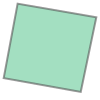

In [24]:
poly = Polygon(bbox_xy)
poly

In [25]:
poly.bounds

(-100.13694111929185,
 18.068982542026124,
 -96.17730760260231,
 21.841270600310185)

In [26]:
poly.__geo_interface__

{'type': 'Polygon',
 'coordinates': (((-99.54163571839928, 21.841270600310185),
   (-96.17730760260231, 21.25939696689257),
   (-96.843173553836, 18.068982542026124),
   (-100.13694111929185, 18.65929018004776),
   (-99.54163571839928, 21.841270600310185)),)}

In [27]:
reference_imgs[0].name

'IMG-HH-ALOS2047853215-150412-WBDR1.1__D-F1'

# Wrapping the ISCE Routines Up and Formatting into Dictionary

In [28]:
def get_slc_metadata(slc_img_name_path):
    
    tokens = slc_img_name_path.name.split('-')
    slc_id = '-'.join(tokens[2:4])
    production_level = tokens[4].split('.')[0]

    # only needs the name of the file not the path
    track = get_alos2_track_obj(slc_img_name_path.name)
    bbox_yxz, sensingStart, sensingEnd = get_bbox_data_from_ISCE(track)
    
    data = {}
    
    data['slc_id'] = slc_id
    data['production_level'] = production_level
    
    bbox_xy = [[coord[1], coord[0]] for coord in bbox_yxz]
    bbox_xy = [bbox_xy[k] for k in [0, 1, 3, 2]]
    data['bbox_xy_coords'] = bbox_xy
    
    data['start_time'] = sensingStart.strftime("%Y-%m-%dT%H:%M:%S.%f")
    data['stop_time'] = sensingEnd.strftime("%Y-%m-%dT%H:%M:%S.%f")
    data['absolute_orbit'] = track.orbitNumber
    data['frame'] = track.frameNumber
    data['flight_direction'] = 'A' if 'ascending' == track.catalog['passdirection'] else 'D'
    data['satellite_name'] = track.spacecraftName
    data['source'] = "isce_preprocessing"
    
    # See: https://github.com/aria-jpl/ariamh
    #/blob/ddf752080a7c614ef99ea3be880506105965699c/frameMetadata/FrameInfoExtractor.py#L155
    track_number = (14 * int(track.orbitNumber) + 24) % 207
    data['track'] = track_number
    
    return data

In [29]:
reference_imgs[0]

PosixPath('ALOS2047853200-150412/IMG-HH-ALOS2047853215-150412-WBDR1.1__D-F1')

In [30]:
reference_md = get_slc_metadata(reference_imgs[0])
reference_md

{'slc_id': 'ALOS2047853215-150412',
 'production_level': 'WBDR1',
 'bbox_xy_coords': [[-99.54163571839928, 21.841270600310185],
  [-96.17730760260231, 21.25939696689257],
  [-96.843173553836, 18.068982542026124],
  [-100.13694111929185, 18.65929018004776]],
 'start_time': '2015-04-12T18:26:03.683087',
 'stop_time': '2015-04-12T18:26:55.705525',
 'absolute_orbit': '04785',
 'frame': '3215',
 'flight_direction': 'D',
 'satellite_name': 'ALOS2',
 'source': 'isce_preprocessing',
 'track': 153}

In [31]:
secondary_md = get_slc_metadata(secondary_imgs[0])
secondary_md

{'slc_id': 'ALOS2041643215-150301',
 'production_level': 'WBDR1',
 'bbox_xy_coords': [[-99.54225234548686, 21.84242172762871],
  [-96.17777138358394, 21.260454461136113],
  [-96.84383040237188, 18.07008971011115],
  [-100.13767953028737, 18.660475516270562]],
 'start_time': '2015-03-01T18:26:06.130416',
 'stop_time': '2015-03-01T18:26:58.152714',
 'absolute_orbit': '04164',
 'frame': '3215',
 'flight_direction': 'D',
 'satellite_name': 'ALOS2',
 'source': 'isce_preprocessing',
 'track': 153}

In [32]:
str(dateparser.parse('2015-03-01T18:26:58.152714'))

'2015-03-01 18:26:58.152714'

In [33]:
def get_center_time(t1, t2):
    # Dateparser.parse reads any datetime
    a = dateparser.parse(t1)
    b = dateparser.parse(t2)
    center_datetime = a + (b - a)/2
    return center_datetime

def get_hash(reference_slc_id, secondary_slc_id):
    slc_str = (reference_slc_id + secondary_slc_id).encode("utf8")
    id_hash = hashlib.md5(slc_str)
    id_hash = id_hash.hexdigest()
    return id_hash


def ifg_cfg_md(reference_md, secondary_md, context):
    ifg_data = {'reference_metadata': reference_md,
                'secondary_metadata': secondary_md
               }
    
    ifg_data['full_ifg_hash'] = get_hash(reference_md['slc_id'],
                                         secondary_md['slc_id'])
    ifg_data['dem_type'] = ctx['dem_type']
    ifg_data['reference_slc'] = reference_md['slc_id']
    ifg_data['secondary_slc'] = secondary_md['slc_id']
    ifg_data["interferogram_type"] = context['ifg_type']
    ifg_data["azimuth_looks"] = int(context['azimuth_looks'])
    ifg_data["range_looks"] = int(context['range_looks'])
    ifg_data["burst_overlap"] = float(context['burst_overlap'])
    ifg_data["filter_strength"] = float(context['filter_strength'])
    
    ifg_data["polarization"] = 'HH'
    ifg_data['sensing_start_time'] = reference_md['start_time']
    ifg_data['sensing_stop_time'] = reference_md['stop_time']
    
    acq_center_time = get_center_time(reference_md['start_time'], 
                                      reference_md['stop_time'])
    ifg_data['sensing_center_time'] = (acq_center_time).strftime("%H%M%S")
    ref_dt = dateparser.parse(reference_md['start_time']).date()
    sec_dt = dateparser.parse(secondary_md['start_time']).date()
    
    ifg_data['reference_date'] = str(ref_dt)
    ifg_data['secondary_date'] = str(sec_dt)
    ifg_data['flight_direction'] = reference_md['flight_direction']
    ifg_data['track'] = reference_md['track']
    
    return ifg_data

In [34]:
ifg_md = ifg_cfg_md(reference_md, 
                    secondary_md, 
                    ctx)
ifg_md

{'reference_metadata': {'slc_id': 'ALOS2047853215-150412',
  'production_level': 'WBDR1',
  'bbox_xy_coords': [[-99.54163571839928, 21.841270600310185],
   [-96.17730760260231, 21.25939696689257],
   [-96.843173553836, 18.068982542026124],
   [-100.13694111929185, 18.65929018004776]],
  'start_time': '2015-04-12T18:26:03.683087',
  'stop_time': '2015-04-12T18:26:55.705525',
  'absolute_orbit': '04785',
  'frame': '3215',
  'flight_direction': 'D',
  'satellite_name': 'ALOS2',
  'source': 'isce_preprocessing',
  'track': 153},
 'secondary_metadata': {'slc_id': 'ALOS2041643215-150301',
  'production_level': 'WBDR1',
  'bbox_xy_coords': [[-99.54225234548686, 21.84242172762871],
   [-96.17777138358394, 21.260454461136113],
   [-96.84383040237188, 18.07008971011115],
   [-100.13767953028737, 18.660475516270562]],
  'start_time': '2015-03-01T18:26:06.130416',
  'stop_time': '2015-03-01T18:26:58.152714',
  'absolute_orbit': '04164',
  'frame': '3215',
  'flight_direction': 'D',
  'satellite_n

## Updating the Metadata with Intersection and Unions

In [35]:
def update_ifg_metadata_with_bbox_data(ifg_data: dict) -> dict:
    
    reference_bbox_coords = ifg_data['reference_metadata']['bbox_xy_coords']
    secondary_bbox_coords = ifg_data['secondary_metadata']['bbox_xy_coords']
    
    reference_poly = Polygon(reference_bbox_coords)
    secondary_poly = Polygon(secondary_bbox_coords)
    
    intersection_geo = reference_poly.intersection(secondary_poly)
    if intersection_geo.is_empty:
        raise ValueError('There is no overlap between SLCs')
    
    union_geo = reference_poly.union(secondary_poly)
    
    ifg_data['union_geojson'] = union_geo.__geo_interface__
    ifg_data['intersection_geojson'] = intersection_geo.__geo_interface__
    
    # xmin, ymin, xmax, ymax
    ifg_data['bounds'] = list(union_geo.bounds)
    
    # Get Latitude string
    lon = ifg_md['bounds'][0]
    lat = ifg_md['bounds'][1]
    ifg_data['longitude_string'] = f"{abs(lon):1.0f}{'W' if lon < 0 else 'E'}"
    ifg_data['latitude_string'] = f"{abs(lat):1.0f}{'N' if lat > 0 else 'S'}"
    return ifg_data

In [36]:
update_ifg_metadata_with_bbox_data(ifg_md)

{'reference_metadata': {'slc_id': 'ALOS2047853215-150412',
  'production_level': 'WBDR1',
  'bbox_xy_coords': [[-99.54163571839928, 21.841270600310185],
   [-96.17730760260231, 21.25939696689257],
   [-96.843173553836, 18.068982542026124],
   [-100.13694111929185, 18.65929018004776]],
  'start_time': '2015-04-12T18:26:03.683087',
  'stop_time': '2015-04-12T18:26:55.705525',
  'absolute_orbit': '04785',
  'frame': '3215',
  'flight_direction': 'D',
  'satellite_name': 'ALOS2',
  'source': 'isce_preprocessing',
  'track': 153},
 'secondary_metadata': {'slc_id': 'ALOS2041643215-150301',
  'production_level': 'WBDR1',
  'bbox_xy_coords': [[-99.54225234548686, 21.84242172762871],
   [-96.17777138358394, 21.260454461136113],
   [-96.84383040237188, 18.07008971011115],
   [-100.13767953028737, 18.660475516270562]],
  'start_time': '2015-03-01T18:26:06.130416',
  'stop_time': '2015-03-01T18:26:58.152714',
  'absolute_orbit': '04164',
  'frame': '3215',
  'flight_direction': 'D',
  'satellite_n

In [37]:
json.dump(ifg_md['intersection_geojson'],
          open('intersection.geojson', 'w'),
          indent=2)

json.dump(ifg_md['union_geojson'],
          open('union.geojson', 'w'),
          indent=2)

In [38]:
json.dump(box(*ifg_md['bounds']).__geo_interface__,
          open('bounds.geojson', 'w'),
          indent=2)

# Save Metadata

## Get Product ID and Make Product Directory

In [39]:
keys = ['flight_direction',
        'track',
        'reference_date',
        'secondary_date',
        'sensing_center_time',
        'latitude_string',
        'longitude_string'
        ]
string_data = [str(ifg_md[key]) for key in keys]
# remove '-' tokens
string_data = list(map(lambda x: x.replace('-', ''), string_data))
# include version
string_data += [VERSION.replace('.','_')]
string_data

['D', '153', '20150412', '20150301', '182629', '18N', '100W', 'v1_0_0']

In [40]:
prod_id = 'ALOS2-GUNW-' + '-'.join(string_data)
prod_id

'ALOS2-GUNW-D-153-20150412-20150301-182629-18N-100W-v1_0_0'

In [41]:
prod_dir_path = Path(prod_id)
prod_dir_path.mkdir(exist_ok=True, parents=True)

## Save `met.json` for HySDS

This is just the ifg_data

In [42]:
out_path = prod_dir_path/f'{prod_id}.met.json'
json.dump(ifg_md,
          open(out_path, 'w'),
          indent=2)

## Save `dataset.json` for HySDS


In [43]:
# build dataset
dataset = {'creation_timestamp': f'{datetime.datetime.utcnow().isoformat()}Z',
           'version': VERSION,
           'label': prod_id,
           'location': ifg_md['union_geojson'],
           'starttime': ifg_md['sensing_start_time'],
           'endtime': ifg_md['sensing_stop_time']}
dataset

{'creation_timestamp': '2021-03-25T00:58:48.447865Z',
 'version': 'v1.0.0',
 'label': 'ALOS2-GUNW-D-153-20150412-20150301-182629-18N-100W-v1_0_0',
 'location': {'type': 'Polygon',
  'coordinates': (((-96.17796830232892, 21.259511237480126),
    (-96.17730760260231, 21.25939696689257),
    (-96.843173553836, 18.068982542026124),
    (-100.13694111929185, 18.65929018004776),
    (-100.13675051187933, 18.66030900005793),
    (-100.13767953028737, 18.660475516270562),
    (-99.54225234548686, 21.84242172762871),
    (-96.17777138358394, 21.260454461136113),
    (-96.17796830232892, 21.259511237480126)),)},
 'starttime': '2015-04-12T18:26:03.683087',
 'endtime': '2015-04-12T18:26:55.705525'}

In [44]:
out_path = prod_dir_path/f'{prod_id}.dataset.json'
json.dump(dataset,
          open(out_path, 'w'),
          indent=2)